# INSTRUÇÃO PRÁTICA 009
## Revisao e consolidaçao do conteúdo de __Pandas__ avançado.
Para a pratica serão utilizados dados de estações metereologicas de Salvador dos anos de 2003, 2013 e 2023, diponiveis em: [Instituto Nacional de Meteorologia](https://portal.inmet.gov.br/dadoshistoricos). 

Os dados foram limpos e unidos em um unico DataFrama, com MultiIndex para colunas e indexadas por um DateTimeIndex.

### Carregando os dados

In [787]:
import pandas as pd

estacao_ssa_2003 = pd.read_csv('./datasets/estacao_Salvador_2003.CSV', header=8, sep=';', encoding='latin-1')
estacao_ssa_2013 = pd.read_csv('./datasets/estacao_Salvador_2013.CSV', header=8, sep=',', encoding='utf-8')
estacao_ssa_2023 = pd.read_csv('./datasets/estacao_Salvador_2023.CSV', header=8, sep=';', encoding='latin-1')
print()

### Tratamento de dados

1. Removendo coluna extra unnamed

In [788]:
estacao_ssa_2003.drop(columns=['Unnamed: 19'], inplace=True)
estacao_ssa_2023.drop(columns=['Unnamed: 19'], inplace=True)

2. Unificando nomes de colunas

In [789]:
# pegando lista de nomes de colunas de cada dataframe
colunas_2003 = estacao_ssa_2003.columns.values.tolist() 
colunas_2013 = estacao_ssa_2013.columns.values.tolist()
colunas_2023 = estacao_ssa_2023.columns.values.tolist()

# renomeando colunas diferentes para o nome da coluna do dataframe de 2003
for c_2003, c_2013, c_2023 in zip(colunas_2003, colunas_2013, colunas_2023):
    if c_2003 != c_2013 or c_2003 != c_2023:
        estacao_ssa_2013.rename(columns={c_2013: c_2003}, inplace=True)
        estacao_ssa_2023.rename(columns={c_2023: c_2003}, inplace=True)
        

# concatenando os dataframes
estacao_ssa = pd.concat([estacao_ssa_2003, estacao_ssa_2013, estacao_ssa_2023], ignore_index=True)

3. Criando DateTimeIndex

In [790]:
# tratando coluna hora
mask_utc = estacao_ssa['HORA (UTC)'].str.contains('UTC')  # mascara para pegar apenas os dados com UTC

# trantando dados utc
dados_utc = estacao_ssa.loc[mask_utc, 'HORA (UTC)']
dados_utc = dados_utc.replace(' UTC', '', regex=True) # removendo UTC
dados_utc = dados_utc.str[0:2] + ':00' # pegando apenas a hora

# colocando os dados tratados no dataframe
estacao_ssa.loc[mask_utc, 'HORA (UTC)'] = dados_utc.values

In [791]:
# tratando coluna data
estacao_ssa['DATA (YYYY-MM-DD)'] = estacao_ssa['DATA (YYYY-MM-DD)'].str.replace('/', '-')

In [792]:
# criando DateTimeIndex a partir da coluna DATA (YYYY-MM-DD) e HORA (UTC)
estacao_ssa_index = pd.to_datetime(estacao_ssa['DATA (YYYY-MM-DD)'] + ' ' + estacao_ssa['HORA (UTC)'])

# removendo as colunas originais DATA (YYYY-MM-DD) e HORA (UTC)
estacao_ssa.drop(['DATA (YYYY-MM-DD)', 'HORA (UTC)'], axis=1, inplace=True)

# Define a coluna DATA HORA como índice
estacao_ssa.set_index(estacao_ssa_index, inplace=True)

4. Criando MultiIndex para colunas

In [793]:
# agrupando parametros de medição
nivel_1 = ['precipitacao'] + ['pressao']*3 + ['radiacao'] + ['temperatura']*6 + ['umidade']*3 + ['velocidade do vento']*3
nivel_2 = colunas_2003[2:]

# definindo multiindex para as colunas
index_col = pd.MultiIndex.from_arrays([nivel_1, nivel_2], names=['medicao', 'tipo'])

estacao_ssa.columns = index_col

5. Removendo colunas desnecessárias

In [794]:
estacao_ssa.drop(['pressao', 'radiacao', 'umidade', 'velocidade do vento'], axis=1, inplace=True)

6. Transformando colunas de string para float

In [795]:
# substiduindo valores , por .
estacao_ssa.replace(',', '.', regex=True, inplace=True)

# convertendo para float
estacao_ssa = estacao_ssa.astype('float64')

7. Tratando valores nulos

In [796]:
# tiranddo todos os possiveis valores nulos
estacao_ssa.replace(['-9999', -9999, -9999.0, '-9999.0'], value= None, inplace=True)

# preenchendo valores nulos
estacao_ssa.bfill(inplace=True)

### DataFrame final

In [797]:
estacao_ssa.head()

medicao                                 precipitacao   
tipo                PRECIPITAÇÃO TOTAL, HORÁRIO (mm)   
2003-01-01 00:00:00                              0.0  \
2003-01-01 01:00:00                              0.0   
2003-01-01 02:00:00                              0.0   
2003-01-01 03:00:00                              0.0   
2003-01-01 04:00:00                              0.0   

medicao                                              temperatura   
tipo                TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)   
2003-01-01 00:00:00                                         26.4  \
2003-01-01 01:00:00                                         26.4   
2003-01-01 02:00:00                                         26.4   
2003-01-01 03:00:00                                         26.4   
2003-01-01 04:00:00                                         26.4   

medicao                                                    
tipo                TEMPERATURA DO PONTO DE ORVALHO (°C)   
2003-01-01 00:00:00                                 22.0  \
2003-01-01 01:00:00                                 22.0   
2003-01-01 02:00:00                                 22.0   
2003-01-01 03:00:00                                 22.0   
2003-01-01 04:00:00                                 22.0   

medicao                                                          
tipo                TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)   
2003-01-01 00:00:00                                       27.2  \
2003-01-01 01:00:00                                       27.2   
2003-01-01 02:00:00                                       27.2   
2003-01-01 03:00:00                                       27.2   
2003-01-01 04:00:00                                       27.2   

medicao                                                          
tipo                TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)   
2003-01-01 00:00:00                                       26.3  \
2003-01-01 01:00:00                                       26.3   
2003-01-01 02:00:00                                       26.3   
2003-01-01 03:00:00                                       26.3   
2003-01-01 04:00:00                                       26.3   

medicao                                                                
tipo                TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)   
2003-01-01 00:00:00                                             22.6  \
2003-01-01 01:00:00                                             22.6   
2003-01-01 02:00:00                                             22.6   
2003-01-01 03:00:00                                             22.6   
2003-01-01 04:00:00                                             22.6   

medicao                                                               
tipo                TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)  
2003-01-01 00:00:00                                             21.0  
2003-01-01 01:00:00                                             21.0  
2003-01-01 02:00:00                                             21.0  
2003-01-01 03:00:00                                             21.0  
2003-01-01 04:00:00                                             21.0

In [798]:
estacao_ssa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2003-01-01 00:00:00 to 2023-12-31 23:00:00
Data columns (total 7 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   (precipitacao, PRECIPITAÇÃO TOTAL, HORÁRIO (mm))                 26280 non-null  float64
 1   (temperatura, TEMPERATURA DO AR - BULBO SECO, HORARIA (°C))      26280 non-null  float64
 2   (temperatura, TEMPERATURA DO PONTO DE ORVALHO (°C))              26280 non-null  float64
 3   (temperatura, TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C))        26280 non-null  float64
 4   (temperatura, TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C))        26280 non-null  float64
 5   (temperatura, TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C))  26280 non-null  float64
 6   (temperatura, TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C))  26280 non-null  float64
dtypes: flo

In [799]:
estacao_ssa.describe()

medicao                     precipitacao   
tipo    PRECIPITAÇÃO TOTAL, HORÁRIO (mm)   
count                       26280.000000  \
mean                            0.202785   
std                             1.333296   
min                             0.000000   
25%                             0.000000   
50%                             0.000000   
75%                             0.000000   
max                            52.000000   

medicao                                  temperatura   
tipo    TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)   
count                                   26280.000000  \
mean                                       25.867500   
std                                         2.377785   
min                                        19.500000   
25%                                        24.000000   
50%                                        25.600000   
75%                                        27.300000   
max                                        39.700000   

medicao                                        
tipo    TEMPERATURA DO PONTO DE ORVALHO (°C)   
count                           26280.000000  \
mean                               21.679768   
std                                 1.382037   
min                                14.700000   
25%                                20.700000   
50%                                21.900000   
75%                                22.600000   
max                                26.600000   

medicao                                              
tipo    TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)   
count                                 26280.000000  \
mean                                     26.370327   
std                                       2.527563   
min                                      20.100000   
25%                                      24.400000   
50%                                      26.000000   
75%                                      28.000000   
max                                      43.300000   

medicao                                              
tipo    TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)   
count                                 26280.000000  \
mean                                     25.393565   
std                                       2.185660   
min                                      19.300000   
25%                                      23.700000   
50%                                      25.200000   
75%                                      26.700000   
max                                      33.000000   

medicao                                                    
tipo    TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)   
count                                       26280.000000  \
mean                                           22.143900   
std                                             1.449447   
min                                            15.300000   
25%                                            21.200000   
50%                                            22.300000   
75%                                            23.200000   
max                                            27.400000   

medicao                                                   
tipo    TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)  
count                                       26280.000000  
mean                                           21.228242  
std                                             1.421677  
min                                            -1.800000  
25%                                            20.300000  
50%                                            21.500000  
75%                                            22.300000  
max                                            25.100000

### Analise de dados

In [800]:
import matplotlib.pyplot as plt
%matplotlib widget

1. Subplot com evolução das temperaturas médias e acumulado de precipitações nos três anos.

2. Acumulado de precipitações de Junho nos três anos.

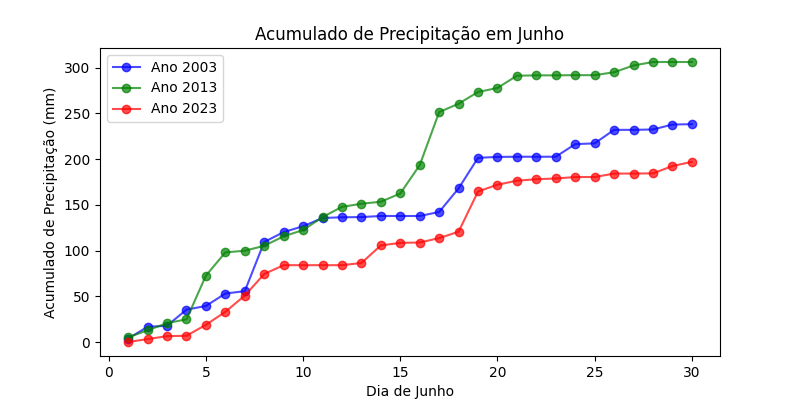

In [803]:

dados_junho = estacao_ssa[('precipitacao', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)')][estacao_ssa.index.month == 6]

# Agrupando por ano e somar as precipitações de junho
acumulado_junho_por_ano = dados_junho.groupby([dados_junho.index.year, dados_junho.index.day]).sum().groupby(level=0).cumsum()

# Criando o gráfico de linha para o acumulado de precipitação
plt.figure(figsize=(8, 4))
cores = ['blue', 'green', 'red']  # Defina cores diferentes para cada ano

for i, (ano, dados) in enumerate(acumulado_junho_por_ano.groupby(acumulado_junho_por_ano.index.get_level_values(0))):
  plt.plot(dados.index.get_level_values(1), dados.values, color=cores[i], alpha=0.7, label=f'Ano {ano}', marker='o')  # Adicionando marcadores para cada ponto

plt.title('Acumulado de Precipitação em Junho')
plt.xlabel('Dia de Junho')
plt.ylabel('Acumulado de Precipitação (mm)')
plt.legend()
plt.show()


3. Temperatura media de cada um dos dias de Março nos três anos.

4. Temperatura máxima e mínima de cada uma das estações nos tres anos. Sendo:
   - Verão (Janeiro, Fevereiro e Março)
   - Outono (Abril, Maio e Junho) 
   - Inverno (Julho, Agosto e Setembro)
   - Primavera (Outubro, Novembro e Dezembro).

5. Comportamente de temperatura media do dia 28 de Setembro em cada um dos intervalos do dia dos três anos. Sendo:
   - Madrugada (00:00 a 06:00), 
   - Manha (06:00 a 12:00)
   - Tarde (12:00 a 18:00)
   - Noite (18:00 a 00:00)